<a href="https://colab.research.google.com/github/Nexx136/sandbox/blob/master/rl_week1_hw.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#! pip install --upgrade ipykernel

In [16]:
import gym
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# 0. Инициализация среды и ее свойства

Посмотрим как выглядит среда, какую в среднем награду получает агент и сколько длится эпизод. После оптимизации награда должна стать больше, а длительность меньше

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym

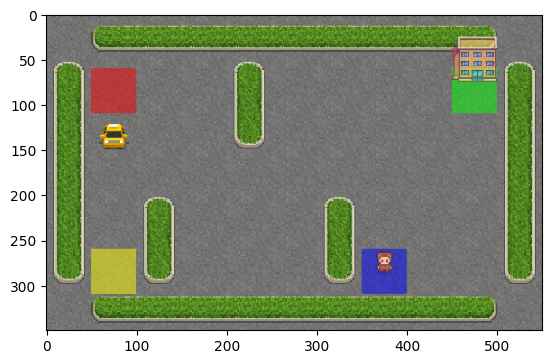

In [3]:
env = gym.make('Taxi-v3')
render = lambda : plt.imshow(env.render(mode='rgb_array'))
env.reset()
render()

In [4]:
env.action_space

Discrete(6)


    

```
такси может делать такие действия:
    0: move south
    1: move north
    2: move east
    3: move west
    4: pickup passenger
    5: drop off passenger
```




In [5]:
print(f' такси может принимать {env.observation_space} состояний ')

 такси может принимать Discrete(500) состояний 


# 1. Задание 1. Оптимизация алгоритма методом кросс-энтропии

## 1.1   статистики в случае случайного выбора действий

запустим 500 эпизодов чтобы посмотреть на среднююю длительность и награду. Далее мы эти данные для обучения использовать не будем.

In [6]:
%%time
rewards = []
steps = []
for _ in range(500):
    done = False
    num_steps = 0
    total_reward = 0
    env.reset()
    while not done:
        action = np.random.choice(6, size=1)[0]
        next_state, reward, done, info = env.step(action)
        num_steps += 1
        total_reward += reward
    rewards.append(total_reward)
    steps.append(num_steps)

CPU times: user 4.85 s, sys: 503 ms, total: 5.35 s
Wall time: 5.2 s


In [7]:
print(f'''0.90 - 0.99 quantiles for reward:
0.90 :{np.quantile(rewards, 0.9)},
0.95 :{np.quantile(rewards, 0.95)},
0.975:{np.quantile(rewards, 0.975)},
0.99 :{np.quantile(rewards, 0.99)},
on average we get reward: {np.mean(rewards)} with {np.mean(num_steps)} steps.
''')

0.90 - 0.99 quantiles for reward:
0.90 :-695.0,
0.95 :-658.7000000000003,
0.975:-591.8000000000002,
0.99 :-375.9000000000001,
on average we get reward: -773.886 with 200.0 steps.



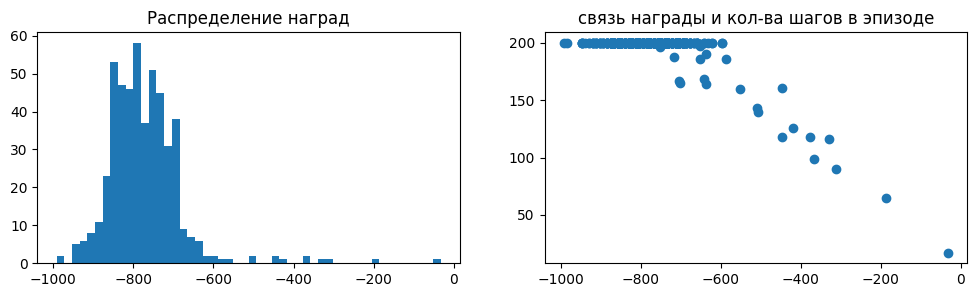

In [8]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 3))
ax[0].hist(rewards, bins=50)
ax[0].set_title('Распределение наград')
ax[1].scatter(rewards, steps)
ax[1].set_title('связь награды и кол-ва шагов в эпизоде');

## 1.2 метод кросс-энтропии для разных значений гиперпараметров

Найдем наилучшие значения гиперпараметров, при которых в среднем будем получать не отрицательный reward за 1000 итераций. Перебирать будем значения:


*   q = [0.7, 0.8, 0.85, 0.9, 0.95, 0.99]
*   trajectory_n (кол-во эпизодов в итерации) = [20, 50] + попробуем вариант с апдейтом политики после каждого элитного эпизода

Лучшим будем считать тот вариант, который будет приносить не отрицательную награду за наименьшее число шагов. остановимся, когда среднее по последним trajectory_n будет >=0






определим вспомогательные функции:

In [9]:
def update_strategy(cool_model:np.array, curr_strategy:list):
    '''
        функция  принимает на вход матрицу для принятия решения о действии cool_model и апдейтит ее значения по переданному эпизоду s
    '''
    for c in curr_strategy:
        cool_model[c[0], c[1]] += 1
    return cool_model

In [18]:
q = [0.7, 0.8, 0.85, 0.9, 0.95, 0.99]
trajectory = [1, 20, 50]
logs = []
n_states, n_actions = 500, 6
iteration_n0 = 100
iteration_n = iteration_n0 * trajectory[2]


for q_i in q:
    for t in trajectory:
        mean_reward = - 1000
        thres = -1000
        cool_model = np.ones((n_states, n_actions))

        n_episodes = 0
        n_updated = 0
        while n_episodes<=1000 :

            trajectory_stats = []

            for t_i in range(t):
                n_steps = 0
                trajectory_reward = 0
                done=False
                curr_strategy = []

                state = env.reset()

                while not done:
                    action = np.random.choice(6, size=1, p=cool_model[state, :] / np.sum(cool_model[state, :] ))[0]
                    next_state, reward, done, info = env.step(action)
                    curr_strategy.append([state, action, reward])
                    state = next_state
                    trajectory_reward += reward
                    n_steps += 1

                if t == 1:
                    if trajectory_reward>=thres:
                        cool_model = update_strategy(cool_model, curr_strategy)
                        try:
                            thres = np.quantile([l[2] for l in logs], q_i)
                            n_updated += 1
                        except IndexError:
                            pass

                n_episodes += 1
                trajectory_stats.append([n_steps,  trajectory_reward,  thres, q_i, t, curr_strategy,  n_episodes, n_updated])

            if t >1:
                for t_i in trajectory_stats:
                    if  t_i[1]>thres:
                        cool_model = update_strategy(cool_model, t_i[5])
                        n_updated += 1


            mean_reward = np.mean([c[1] for c in trajectory_stats])
            new_thres = np.quantile([c[1] for c in trajectory_stats], q_i)
            if t>1 and new_thres>thres:
                thres = new_thres
            logs.append([q_i, t, mean_reward, thres, n_episodes, n_updated, n_steps])

            if n_episodes % 500 ==0:
                print(q_i, t, thres, mean_reward,  n_updated, n_episodes)

0.7 1 -614.0 -884.0 252 500
0.7 1 -569.0 -569.0 499 1000
0.7 20 -563.6 -704.45 146 500
0.7 20 -358.10000000000014 -590.15 259 1000
0.7 50 -611.3000000000001 -655.3 186 500
0.7 50 -514.4000000000001 -605.68 317 1000
0.8 1 -510.9999999999991 -63.0 146 500
0.8 1 -329.1999999999998 -309.0 475 1000
0.8 20 -219.99999999999997 -542.7 121 500
0.8 20 -166.0 -588.1 164 1000
0.8 50 -406.0 -646.04 140 500
0.8 50 -257.79999999999995 -532.92 228 1000
0.85 1 -300.0 -713.0 35 500
0.85 1 -258.0 -415.0 185 1000
0.85 20 -168.80000000000004 -660.65 75 500
0.85 20 -96.00000000000003 -658.05 108 1000
0.85 50 -592.1 -710.64 120 500
0.85 50 -328.35 -632.86 199 1000
0.9 1 -215.5 -839.0 12 500
0.9 1 -224.0 -686.0 39 1000
0.9 20 -257.09999999999974 -693.95 55 500
0.9 20 -116.8 -690.4 73 1000
0.9 50 -356.69999999999976 -711.74 99 500
0.9 50 -154.2 -656.94 127 1000
0.95 1 -154.30000000000018 -785.0 5 500
0.95 1 -156.44999999999982 -309.0 21 1000
0.95 20 -215.24999999999994 -692.9 38 500
0.95 20 -74.74999999999996 

In [38]:
res = pd.DataFrame(logs, columns=['q_i', 't', 'mean_reward', 'thres', 'n_episodes', 'n_updated', 'n_steps'])
res['n_episodes_q'] = pd.cut(res['n_episodes'], bins=np.arange(11)*100)
res['n_updated_q'] = pd.cut(res['n_updated'], bins=np.arange(20)*50)

Выберем гиперпараметры, при которых средняя награда за последние 100 эпизодов наибольшая (понимаем, что целевая метрика очень шумная)

<Axes: xlabel='t', ylabel='q_i'>

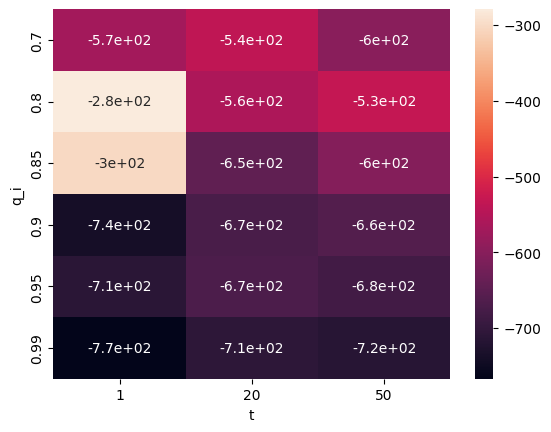

In [24]:
sns.heatmap(pd.pivot_table(res[res['n_episodes']>950], index='q_i', columns='t', values='mean_reward', aggfunc='median'), annot=True)

<b> выберем квантиль 0.80 и кол-во эпизодов в батче - 50. (несмотря на то, что при батче 1 результат получаем выше, считаем, что это случайный результат  </b>

Посмотрим, как зависит рост средней награды от кол-ва эпизодов:

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<Axes: xlabel='n_episodes_q'>

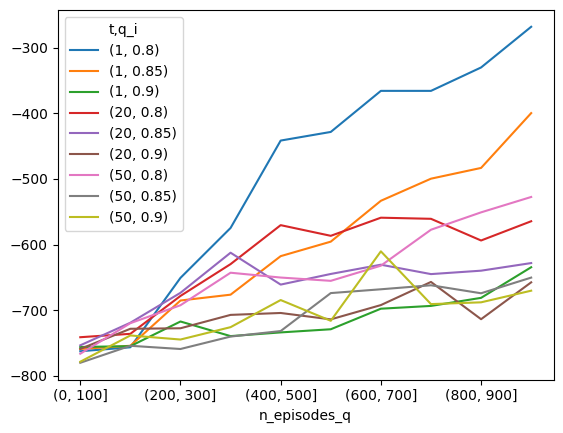

In [28]:
pd.pivot_table(res[res['q_i'].isin([0.8, 0.85, 0.9])], index=[ 't', 'q_i'], columns='n_episodes_q', values='mean_reward', aggfunc='mean').T.plot()

Посмотрим, как зависит рост среднй награды от кол-ва апдейтов. Очевидно, что чем больше раз удалось обновить политику, тем быстрее метод сойдется

In [39]:
pd.pivot_table(res[res['q_i'].isin([ 0.85])], index=[ 't', 'q_i'], columns='n_updated_q', values='mean_reward', aggfunc='mean')

,n_updated_q,"(0, 50]","(50, 100]","(100, 150]","(150, 200]","(200, 250]"
t,q_i,,,,,
1,0.85,-683.304498,-534.758065,-481.687500,-379.363636,NaN
20,0.85,-744.255556,-645.250000,-636.168182,NaN,NaN
50,0.85,-782.860000,-753.490000,-708.996667,-661.551429,-576.92


# 2.0 добавляем laplace smoothing и policу smoothing

In [40]:
def update_strategy_with_laplace(cool_model, curr_strategy, my_lambda=0.5):
    for c in curr_strategy:
        cool_model[c[0], c[1]] += 1
        cool_model[c[0], :] += my_lambda
    return cool_model

In [41]:
def update_strategy_with_policy(cool_model:np.array, curr_strategy:list, my_lambda=0.5):

    for c in curr_strategy:
        prev_model = cool_model[c[0], :].copy()
        new_model = prev_model.copy()
        new_model[c[1]] += 1
        cool_model[c[0], :] = my_lambda * new_model + (1 - my_lambda) * prev_model
    return cool_model

Запустим алгоритм с гиперпараметрами, отобранными на 1м шаге с двумя модификациями стратегии и выберем наилучший вариант.

In [60]:
q_i = 0.80
t = 50

In [61]:
logs = []

for my_lambda in [0.2, 0.5, 0.8, 1, ]:
    for i in range(1,3):
        mean_reward = - 1000
        thres = -1000
        cool_model = np.ones((n_states, n_actions))

        n_episodes = 0
        n_updated = 0

        while n_episodes<=1000 :
            trajectory_stats = []
            for t_i in range(t):


                n_steps = 0
                trajectory_reward = 0
                done=False
                curr_strategy = []

                state = env.reset()

                while not done:
                    action = np.random.choice(6, size=1, p=cool_model[state, :] / np.sum(cool_model[state, :] ))[0]
                    next_state, reward, done, info = env.step(action)
                    curr_strategy.append([state, action, reward])
                    state = next_state
                    trajectory_reward += reward
                    n_steps += 1

                n_episodes += 1
                trajectory_stats.append([n_steps,  trajectory_reward,  thres, q_i, t, curr_strategy,  n_episodes, n_updated, my_lambda, i])


                for t_i in trajectory_stats:
                    if t_i[1]>=thres:
                        n_updated += 1
                        if i==0:
                            cool_model = update_strategy(cool_model, t_i[5])
                        elif i==1:
                            cool_model = update_strategy_with_laplace(cool_model, t_i[5],my_lambda)
                        elif i==2:
                            cool_model = update_strategy_with_policy(cool_model, t_i[5],my_lambda)

                new_thres = np.quantile([c[1] for c in trajectory_stats], q_i)
                if t>1 and new_thres>thres:
                    thres = new_thres

                mean_reward = np.mean([c[1] for c in trajectory_stats])
                logs.append([i, my_lambda, mean_reward, thres, n_episodes, n_updated, n_steps])

                if n_episodes % 500 ==0:
                    print(q_i, my_lambda, i, thres, mean_reward, n_updated, n_episodes)

0.8 0.2 1 -194.0 -680.26 1183 500
0.8 0.2 1 -194.0 -620.12 1429 1000
0.8 0.2 2 -75.0 -686.62 992 500
0.8 0.2 2 -75.0 -601.18 1328 1000
0.8 0.5 1 -218.0 -745.66 861 500
0.8 0.5 1 -218.0 -717.64 1202 1000
0.8 0.5 2 -71.79999999999997 -637.66 1261 500
0.8 0.5 2 -71.79999999999997 -480.0 2024 1000
0.8 0.8 1 -252.0 -747.02 335 500
0.8 0.8 1 -252.0 -766.72 567 1000
0.8 0.8 2 -169.4 -549.26 1734 500
0.8 0.8 2 -12.399999999999999 -540.6 1816 1000
0.8 1 1 -456.1999999999998 -750.26 1075 500
0.8 1 1 -397.0 -745.82 1811 1000
0.8 1 2 -8.0 -701.06 557 500
0.8 1 2 -8.0 -677.24 763 1000


In [62]:
res2 = pd.DataFrame(logs, columns=['i', 'my_lambda', 'mean_reward', 'thres', 'n_episodes', 'n_updated', 'n_steps'])
res2['n_episodes_q'] = pd.cut(res2['n_episodes'], bins=np.arange(15)*200)

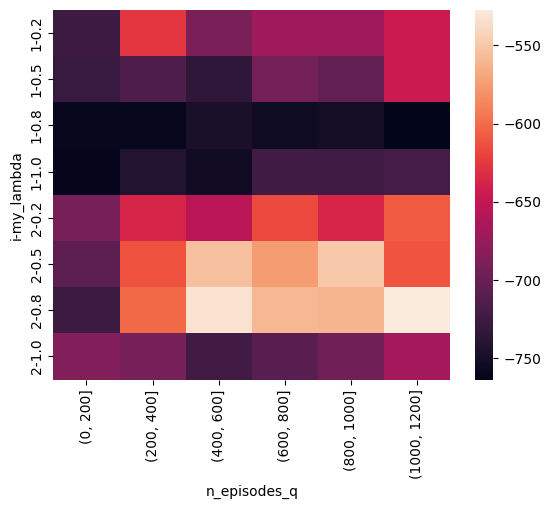

In [65]:
sns.heatmap(pd.pivot_table(res2, index=[ 'i', 'my_lambda'], columns='n_episodes_q', values='mean_reward', aggfunc='mean'));

In [66]:
pd.pivot_table(res2, index=[ 'i', 'my_lambda'], columns='n_episodes_q', values='mean_reward', aggfunc='mean')

n_episodes_q    (0, 200]  (200, 400]  (400, 600]  (600, 800]  (800, 1000]  \
i my_lambda                                                                 
1 0.2        -726.556944 -626.746623 -688.881539 -669.701436  -670.286344   
  0.5        -728.304208 -715.413350 -734.671210 -693.972944  -703.643329   
  0.8        -759.295294 -759.319393 -747.381241 -754.766005  -752.301188   
  1.0        -761.496815 -741.927708 -752.673161 -723.455687  -723.684006   
2 0.2        -692.217056 -636.629233 -654.716484 -617.422807  -637.387610   
  0.5        -706.718033 -612.684199 -554.499882 -575.062343  -549.494529   
  0.8        -726.317159 -601.352093 -533.699653 -559.297435  -561.152973   
  1.0        -685.673592 -692.200145 -722.029036 -709.275378  -695.072591   

n_episodes_q  (1000, 1200]  
i my_lambda                 
1 0.2          -645.854908  
  0.5          -646.385770  
  0.8          -763.483161  
  1.0          -720.590657  
2 0.2          -608.788245  
  0.5          -611.457430  
  0.8          -527.477726  
  1.0          -667.851377

Лучшие результаты показала стратегия "policy smoothing" с параметром lambda=0.8

# 4.0 код из семинара

In [ ]:
import gym
#import gym_maze
import numpy as np
import random
import time


# env = gym.make('maze-sample-5x5-v0')
env = gym.make('Taxi-v3')
state_n = 500
action_n = 6


class RandomAgent():
    def __init__(self, action_n):
        self.action_n = action_n

    def get_action(self, state):
        action = np.random.randint(self.action_n)
        return action


class CrossEntropyAgent():
    def __init__(self, state_n, action_n):
        self.state_n = state_n
        self.action_n = action_n
        self.model = np.ones((self.state_n, self.action_n)) / self.action_n

    def get_action(self, state):
        action = np.random.choice(np.arange(self.action_n), p=self.model[state])
        return int(action)

    def fit(self, elite_trajectories):
        new_model = np.zeros((self.state_n, self.action_n))
        for trajectory in elite_trajectories:
            for state, action in zip(trajectory['states'], trajectory['actions']):
                new_model[state][action] += 1

        for state in range(self.state_n):
            if np.sum(new_model[state]) > 0:
                new_model[state] /= np.sum(new_model[state])
            else:
                new_model[state] = self.model[state].copy()

        self.model = new_model
        return None


def get_state(obs):
#    return int(np.sqrt(state_n) * obs[0] + obs[1])
    return obs


def get_trajectory(env, agent, max_len=1000, visualize=False):
    trajectory = {'states': [], 'actions': [], 'rewards': []}

    state = env.reset()
#    state = get_state(obs)

    for _ in range(max_len):
        trajectory['states'].append(state)

        action = agent.get_action(state)
        trajectory['actions'].append(action)

        obs, reward, done, _ = env.step(action)
        trajectory['rewards'].append(reward)

        state = get_state(obs)

        if visualize:
            time.sleep(0.5)
            env.render()

        if done:
            break

    return trajectory


agent = CrossEntropyAgent(state_n, action_n)
q_param = 0.9
iteration_n = 100
trajectory_n = 50

for iteration in range(iteration_n):

    #policy evaluation
    trajectories = [get_trajectory(env, agent) for _ in range(trajectory_n)]
    total_rewards = [np.sum(trajectory['rewards']) for trajectory in trajectories]
    print('iteration:', iteration, 'mean total reward:', np.mean(total_rewards))

    #policy improvement
    quantile = np.quantile(total_rewards, q_param)
    elite_trajectories = []
    for trajectory in trajectories:
        total_reward = np.sum(trajectory['rewards'])
        if total_reward > quantile:
            elite_trajectories.append(trajectory)

    agent.fit(elite_trajectories)

trajectory = get_trajectory(env, agent, max_len=100, visualize=False)
ts = [get_trajectory(env, agent, max_len=100, visualize=False) for _ in range(10) ]
print('total reward:', sum(trajectory['rewards']))
#print('model:')
#print(agent.model)

In [ ]:
agent.model.shape, agent.action_n

In [ ]:
state = env.reset()

In [ ]:
t = get_trajectory(env, agent)

In [ ]:
sum(t['rewards'])

In [ ]:
next_state, reward, done, info = env.step(action)

In [ ]:
agent.model
